In [1]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
import mpld3

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
sns.set() ## matplotlib sns veriyor

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook


%matplotlib inline

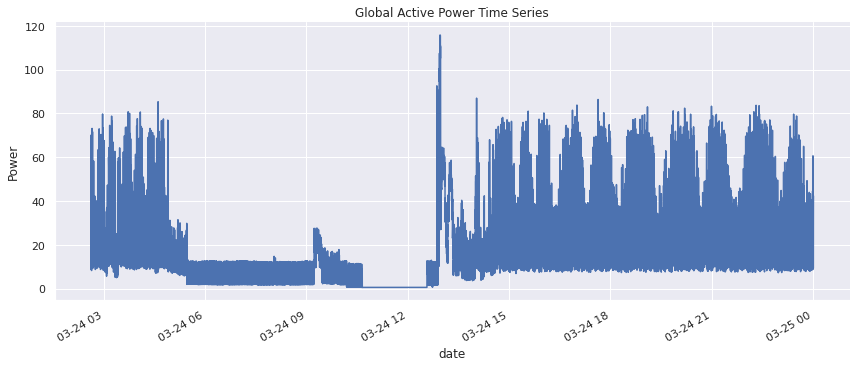

In [7]:
df1.set_index('date',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Power')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Global Active Power Time Series')
sns.despine(top=True)
plt.show();

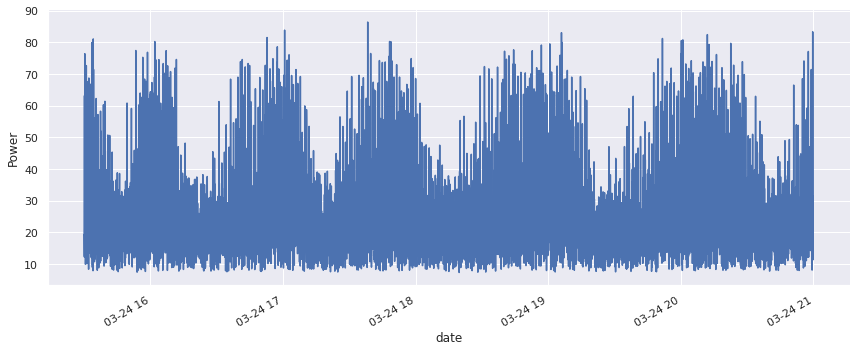

In [8]:
df2=df1[(df1.index>='2020-03-24 15:30:00') & (df1.index<'2020-03-24 21:00:00')]
df2.plot(figsize=(12,5));
plt.ylabel('Power')
plt.legend().set_visible(False)
plt.tight_layout()
sns.despine(top=True)
plt.show();

In [9]:
df0=df.loc[:,['date','Power','E114-EU.CC300.ActCntCyc']] 
df0.set_index('date',inplace=True)
df2=df0[(df0.index>='2020-03-24 15:30:00') & (df0.index<'2020-03-24 20:40:00')]
df_group=df2.reset_index()
df_group=df_group.loc[:,['Power','E114-EU.CC300.ActCntCyc']] 

In [10]:
df_grouped=df_group.groupby("E114-EU.CC300.ActCntCyc").mean()
df_grouped.head()

,Power
E114-EU.CC300.ActCntCyc,
432.0,26.282528
433.0,30.416056
434.0,31.781084
435.0,28.234393
436.0,26.451322


### Data Visualization

In [24]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import math
from seasonal import fit_seasons, adjust_seasons

In [12]:
df4=df_grouped[['Power']]

In [13]:
df4.size

471

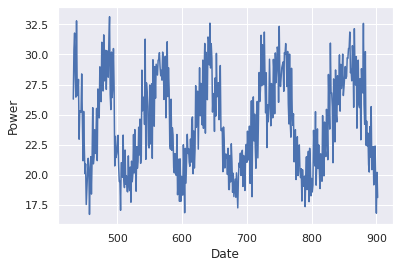

In [14]:
plt.xlabel('Date')
plt.ylabel('Power')
plt.plot(df4)

In [15]:
df4=df4.reset_index(drop=True)
df4.index

RangeIndex(start=0, stop=471, step=1)

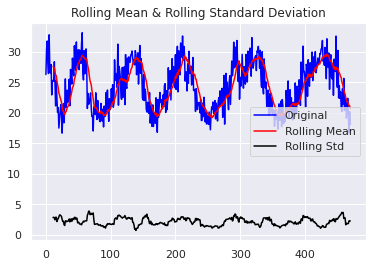

In [16]:
rolling_mean = df4.rolling(window = 12).mean()
rolling_std = df4.rolling(window = 12).std()
plt.plot(df4, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

## Stationary

In [17]:
print(" > Is the data stationary ?")
dftest = adfuller(df4.Power, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    

 > Is the data stationary ?
Test statistic = -4.842
P-value = 0.000
Critical values :
	1%: -3.444900499925237 - The data is  stationary with 99% confidence
	5%: -2.8679556266351653 - The data is  stationary with 95% confidence
	10%: -2.570187288941969 - The data is  stationary with 90% confidence


 ## Seasonality

In [26]:
df4.Power

0      26.282528
1      30.416056
2      31.781084
3      28.234393
4      26.451322
         ...    
466    22.387213
467    19.690747
468    16.797278
469    20.193040
470    18.100720
Name: Power, Length: 471, dtype: float64

In [29]:
seasons, trend = fit_seasons(df4.Power)
adjusted = adjust_seasons(df4.Power, seasons=seasons)
residual = adjusted - trend

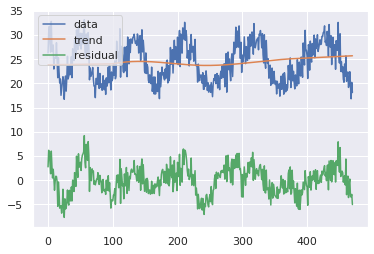

In [31]:
plt.figure()
plt.plot(df4.Power, label='data')
plt.plot(trend, label='trend')
plt.plot(residual, label='residual')
plt.legend(loc='upper left')

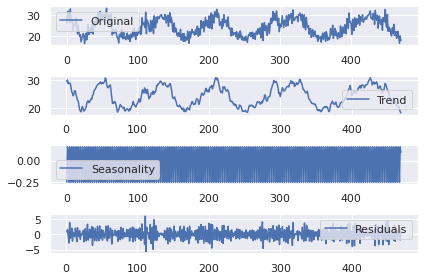

In [37]:
decomposition = sm.tsa.seasonal_decompose(np.asarray(df4.Power), freq=3)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df4.Power, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

## Simple Exponential Smoothing (SES)

SES is a good choice for forecasting data with no clear trend or seasonal pattern.
-  Forecasts are calculated using weighted averages, which means the largest weights are associated with most recent observations, while the smallest weights are associated with the oldest observations:

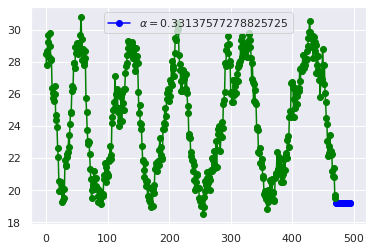

In [40]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

fit3 = SimpleExpSmoothing(df4.Power).fit()
fcast3 = fit3.forecast(24).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])
# plot
fcast3.plot(marker='o', color='blue', legend=True)
fit3.fittedvalues.plot(marker='o', color='green')

plt.show()

## Holt’s Method
Holt extended simple exponential smoothing (solution to data with no clear trend or seasonality) to allow the forecasting of data with trends
- where 0≤ α ≤1 is the level smoothing parameter, and 0≤ β* ≤1 is the trend smoothing parameter.

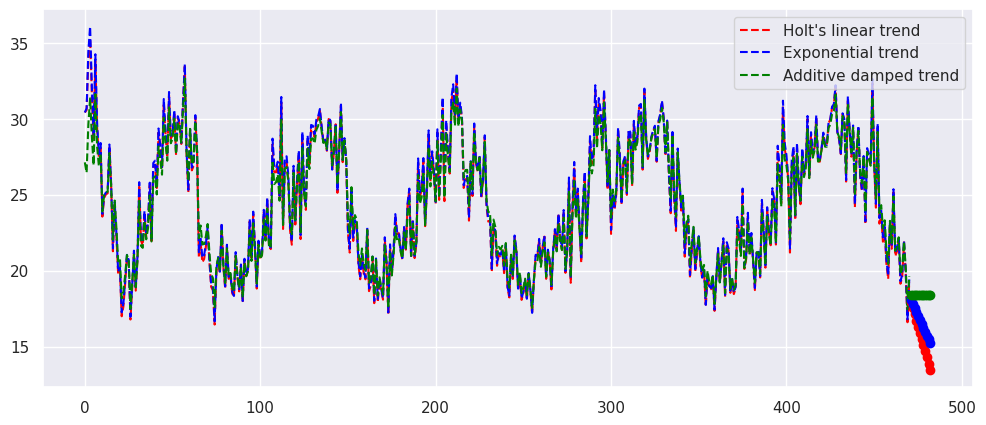

In [74]:
plt.figure(figsize=(12,5), dpi=100)
fit1 = Holt(df4.Power).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast1 = fit1.forecast(12)

fit2 = Holt(df4.Power, exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast2 = fit2.forecast(12)

fit3 = Holt(df4.Power, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
fcast3 = fit3.forecast(12)


fit1.fittedvalues.plot(style='--', color='red')
fit2.fittedvalues.plot(style='--', color='blue')
fit3.fittedvalues.plot(style='--', color='green')

fcast1.plot(color='red', marker="o", legend=True,label="Holt's linear trend")
fcast2.plot(color='blue', marker="o", legend=True,label='Exponential trend')
fcast3.plot(color='green', marker="o", legend=True,label='Additive damped trend')

plt.show()

## Holt-Winters’ Method
Holt-Winters’ Method is suitable for data with trends and seasonalities which includes a seasonality smoothing parameter γ. There are two variations to this method:
- Additive method: the seasonal variations are roughly constant throughout the series.
- Multiplicative method: the seasonal variations are changing proportionally to the level of the series.

In [46]:
df4.Power

0      26.282528
1      30.416056
2      31.781084
3      28.234393
4      26.451322
         ...    
466    22.387213
467    19.690747
468    16.797278
469    20.193040
470    18.100720
Name: Power, Length: 471, dtype: float64

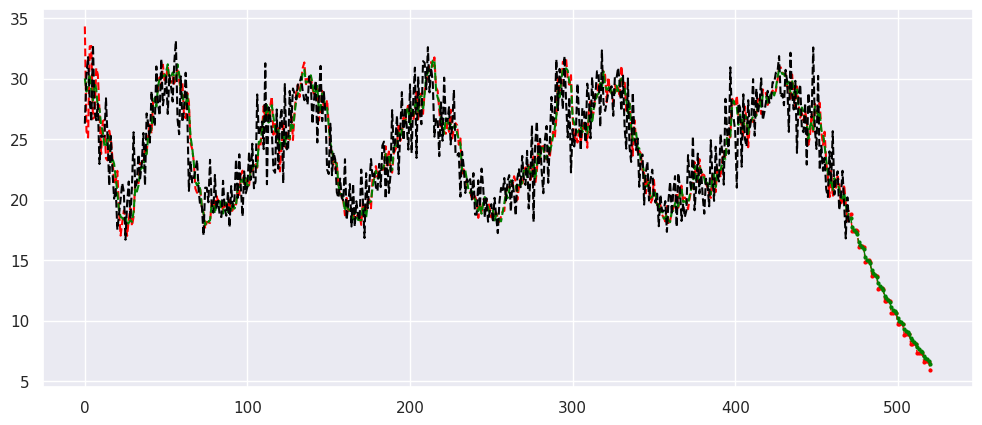

Forecasting sales of properties using Holt-Winters method with both additive and multiplicative seasonality.


In [64]:
plt.figure(figsize=(12,5), dpi=100)
fit1 = ExponentialSmoothing(df4.Power, seasonal_periods=4, trend='add', seasonal='add').fit(use_boxcox=True)
fit2 = ExponentialSmoothing(df4.Power, seasonal_periods=4, trend='add', seasonal='mul').fit(use_boxcox=True)
fit3 = ExponentialSmoothing(df4.Power, seasonal_periods=4, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
fit4 = ExponentialSmoothing(df4.Power, seasonal_periods=4, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
fit1.fittedvalues.plot(style='--', color='red')
fit2.fittedvalues.plot(style='--', color='green')

df4.Power.plot(style='--',color='black')
fit1.forecast(50).plot(color='red', marker='o', linestyle='dashed',linewidth=1, markersize=2)
fit2.forecast(50).plot(color='green', marker='o', linestyle='dashed',linewidth=1, markersize=2)

plt.show()
print("Forecasting sales of properties using Holt-Winters method with both additive and multiplicative seasonality.")

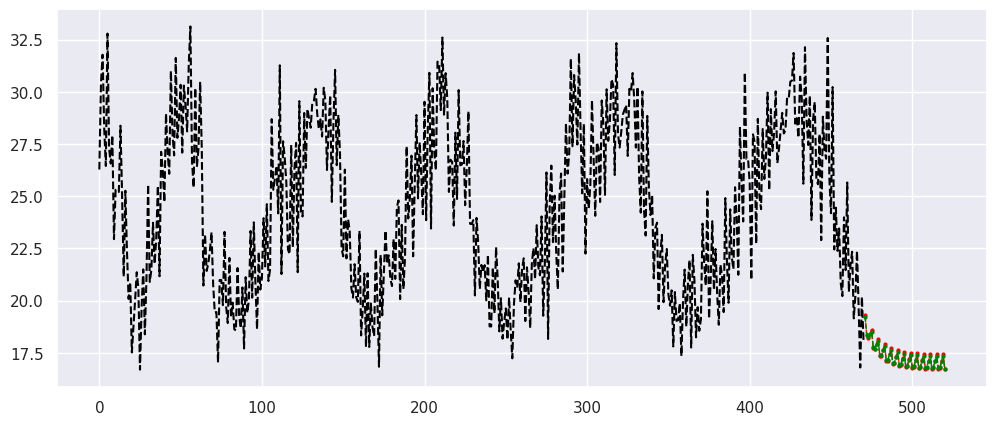

Forecasting sales of properties using Holt-Winters method with both additive and multiplicative seasonality.


In [66]:
plt.figure(figsize=(12,5), dpi=100)
df4.Power.plot(style='--',color='black')
fit3.forecast(50).plot(color='red', marker='o', linestyle='dashed',linewidth=1, markersize=2)
fit4.forecast(50).plot(color='green', marker='o', linestyle='dashed',linewidth=1, markersize=2)

plt.show()
print("Forecasting sales of properties using Holt-Winters method with both additive and multiplicative seasonality.")

### ARIMA 2

In [114]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_model import ARIMA

In [115]:
df5=df4[['Power']]

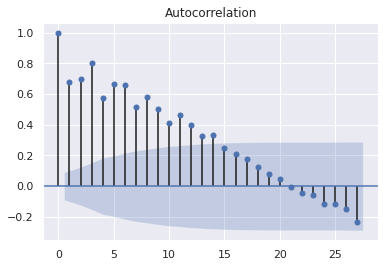

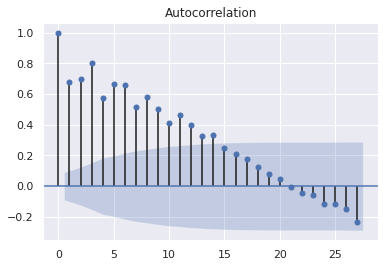

In [116]:
plot_acf(df5)

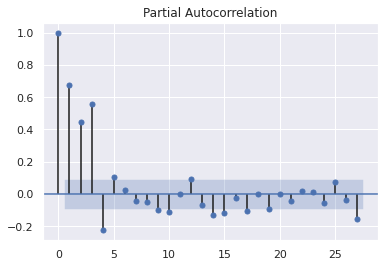

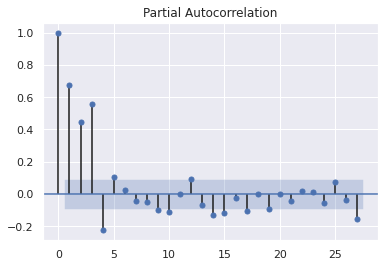

In [133]:
plot_pacf(df5)

## Converting Series to Stationary

In [79]:
df6=df5.diff(periods=1)
#integrated of order 1, denoted by d (for diff)
# diff= out[i] = arr[i+1] – arr[i]

In [80]:
df6=df6[1:]
df6.head()

,Power
1,4.133527
2,1.365029
3,-3.546692
4,-1.783071
5,6.343132


### AutoCorrelation
"Autocorrelations" are numerical values that indicate how a data series is related to itself over time. More precisely, it measures how strongly data values at a specified number of periods apart are correlated to each other over time. The number of periods apart is usually called the "lag". For example, an autocorrelation at lag 1 measures how values 1 period apart are correlated to one another throughout the series. An autocorrelation at lag 2 measures how the data two periods apart are correlated throughout the series. Autocorrelations may range from +1 to -1.

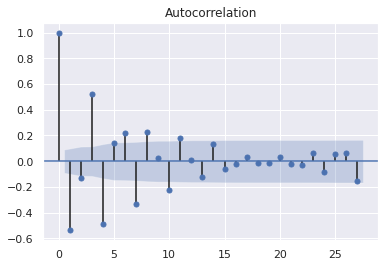

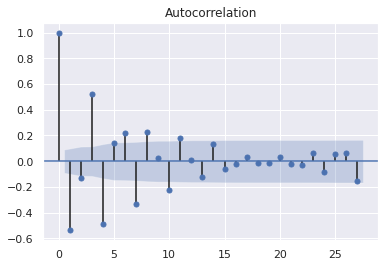

In [83]:
plot_acf(df6)

## Choosing D

 ARIMA(0,0,0) vs  ARIMA(0,1,0)=differenced data

                              ARMA Model Results                              
Dep. Variable:                  Power   No. Observations:                  471
Model:                     ARMA(0, 0)   Log Likelihood                 188.174
Method:                           css   S.D. of innovations              0.162
Date:                Mon, 31 Aug 2020   AIC                           -372.348
Time:                        13:26:02   BIC                           -364.038
Sample:                             0   HQIC                          -369.079
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1800      0.007    425.286      0.000       3.165       3.195
                             ARIMA Model Results                              
Dep. Variable:                D.Power   No. Observat

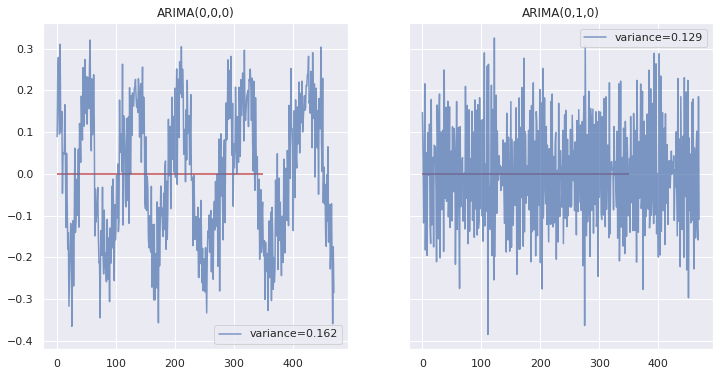

In [88]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(np.log(df5.Power).dropna(), (0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(np.log(df5.Power).dropna(), (0, 1, 0))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=350, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=350, color='r');
ax[1].set_title("ARIMA(0,1,0)");
ax[1].legend();

## Choosing AR

                             ARIMA Model Results                              
Dep. Variable:                D.Power   No. Observations:                  470
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 296.897
Method:                           css   S.D. of innovations              0.129
Date:                Mon, 31 Aug 2020   AIC                           -589.793
Time:                        13:31:18   BIC                           -581.488
Sample:                             1   HQIC                          -586.526
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.006     -0.134      0.894      -0.012       0.011
                             ARIMA Model Results                              
Dep. Variable:                D.Power   No. Observat

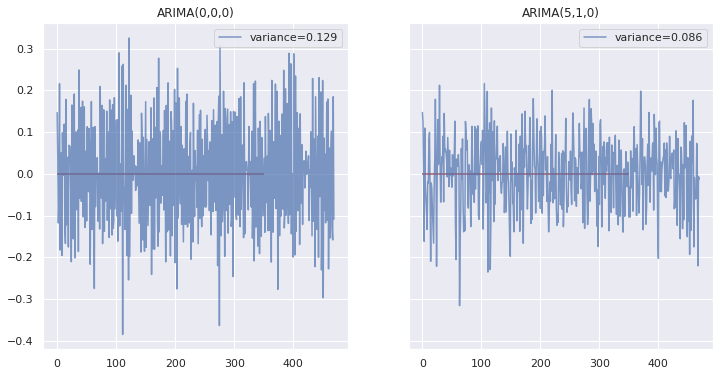

In [96]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(np.log(df5.Power).dropna(), (0, 1, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(np.log(df5.Power).dropna(), (3, 1, 0))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=350, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=350, color='r');
ax[1].set_title("ARIMA(3,1,0)");
ax[1].legend();

## Choosing the MA order

                             ARIMA Model Results                              
Dep. Variable:                D.Power   No. Observations:                  470
Model:                 ARIMA(3, 1, 0)   Log Likelihood                 487.608
Method:                       css-mle   S.D. of innovations              0.086
Date:                Mon, 31 Aug 2020   AIC                           -965.216
Time:                        13:35:17   BIC                           -944.452
Sample:                             1   HQIC                          -957.047
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0009      0.002     -0.472      0.637      -0.005       0.003
ar.L1.D.Power    -0.7423      0.045    -16.395      0.000      -0.831      -0.654
ar.L2.D.Power    -0.4232      0.053     

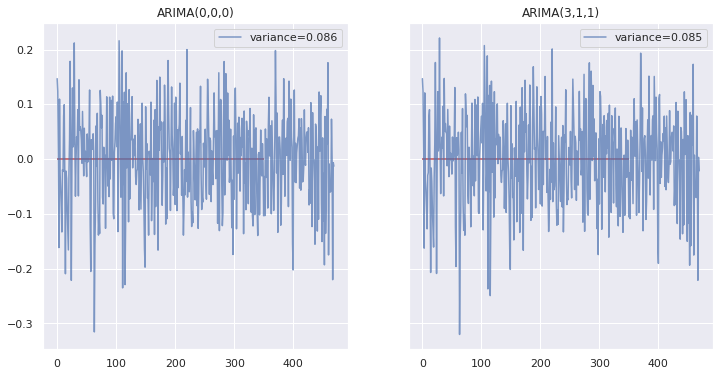

In [103]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(np.log(df5.Power).dropna(), (3, 1, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(np.log(df5.Power).dropna(), (3, 1, 1))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=350, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=350, color='r');
ax[1].set_title("ARIMA(3,1,1)");
ax[1].legend();

In [109]:
res_111

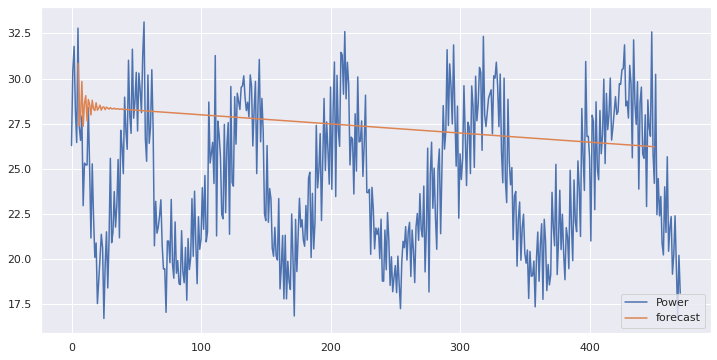

In [118]:
model = ARIMA(df5.Power.dropna()[:-20], (3, 1, 1))
res_111 = model.fit()

fig, ax = plt.subplots(figsize=(12, 6))

df5.Power.dropna().plot(ax=ax);
# - NOTE from the official documentation :
# -- The dynamic keyword affects in-sample prediction. 
# -- If dynamic is False, then the in-sample lagged values are used for prediction. 
# -- If dynamic is True, then in-sample forecasts are used in place of lagged dependent variables.
ax = res_111.plot_predict( dynamic=True, plot_insample=False, ax=ax);

## AR MODEL

X(t) = A(1) * X(t-1) + E(t)

where X(t) = time series under investigation

A(1) = the autoregressive parameter of order 1

X(t-1) = the time series lagged 1 period

E(t) = the error term of the model

This simply means that any given value X(t) can be explained by some function of its previous value, X(t-1), plus some unexplainable random error, E(t). If the estimated value of A(1) was .30, then the current value of the series would be related to 30% of its value 1 period ago.

X(t) = A(1) * X(t-1) + A(2) * X(t-2) + E(t)

This indicates that the current value of the series is a combination of the two immediately preceding values, X(t-1) and X(t-2), plus some random error E(t). Our model is now an autoregressive model of order 2.

## MOVING AVERAGE MODEL

Moving average parameters relate what happens in period t only to the random errors that occurred in past time periods, i.e. E(t-1), E(t-2), etc. rather than to X(t-1), X(t-2), (Xt-3) as in the autoregressive approaches. A moving average model with one MA term may be written as follows...

X(t) = -B(1) * E(t-1) + E(t)

The term B(1) is called an MA of order 1. 

## ARIMA

- p,d,q
- p=periods taken for autoregressive model
- d=integrated order, difference
- q periods in moving average model

In [24]:
# Split data into train / test sets 
# Split data into train / test sets 
train = df4[:330].values
test = df4[330:].values
predictions=[ ]
test.size

141

In [25]:
model_ar= ARIMA(train,order=(2,0,1))
model_ar_fit=model_ar.fit()

In [26]:
predictions=model_ar_fit.forecast(steps=141)[0]
predictions

array([29.69463373, 29.48858707, 29.37176289, 29.23481128, 29.10899116,
       28.98514977, 28.86575567, 28.74994203, 28.63780571, 28.52917132,
       28.42394636, 28.32201897, 28.22328722, 28.1276505 , 28.03501192,
       27.94527744, 27.85835605, 27.77415955, 27.69260251, 27.6136022 ,
       27.53707846, 27.46295365, 27.39115258, 27.32160239, 27.25423252,
       27.18897463, 27.1257625 , 27.06453199, 27.005221  , 26.94776934,
       26.89211873, 26.8382127 , 26.78599657, 26.73541736, 26.68642375,
       26.63896603, 26.59299607, 26.54846721, 26.50533428, 26.46355352,
       26.42308254, 26.38388028, 26.34590697, 26.30912408, 26.2734943 ,
       26.23898147, 26.20555058, 26.17316771, 26.1418    , 26.11141564,
       26.0819838 , 26.05347461, 26.02585916, 25.99910942, 25.97319825,
       25.94809937, 25.92378731, 25.90023741, 25.87742577, 25.85532926,
       25.83392544, 25.81319261, 25.79310973, 25.77365643, 25.75481296,
       25.73656022, 25.71887969, 25.70175341, 25.68516403, 25.66

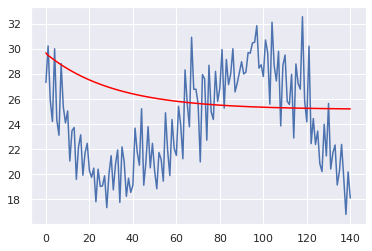

In [27]:
plt.plot(test)
plt.plot(predictions,color='red')

In [28]:
import itertools
p=q=range(0,6)
d=range(0,2)
pdq=list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 0, 5),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 0, 5),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 1, 5),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 0, 5),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 1, 5),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (3, 0, 5),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (3, 1, 5),
 (4, 0, 0),
 (4, 0, 1),
 (4, 0, 2),
 (4, 0, 3),
 (4, 0, 4),
 (4, 0, 5),
 (4, 1, 0),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4),
 (4, 1, 5),
 (5, 0, 0),
 (5, 0, 1),
 (5, 0, 2),
 (5, 0, 3),
 (5, 0, 4),
 (5, 0, 5),
 (5, 1, 0),
 (5, 1, 1),
 (5, 1, 2),
 (5, 1, 3),
 (5, 1, 4),
 (5, 1, 5)]

In [29]:
import warnings
warnings.filterwarnings('ignore')

for param in pdq:
    try:
        model_arima=ARIMA(train,order=param)
        model_arima_fit=model_arima.fit()
        print(param,model_arima_fit.aic)
    except:
        continue
        

(0, 0, 0) 1845.6197059421074
(0, 0, 1) 1716.7460790279927
(0, 0, 2) 1687.005461904263
(0, 0, 3) 1553.4222419239131
(0, 0, 4) 1546.1766025687139
(0, 0, 5) 1540.1277881942656
(0, 1, 0) 1683.1181906363663
(0, 1, 1) 1524.1931564500564
(0, 1, 2) 1498.1105985549275
(0, 1, 3) 1496.8525294950246
(0, 1, 4) 1476.4005929125874
(0, 1, 5) 1449.3900542531305
(1, 0, 0) 1635.2003424375052
(1, 0, 1) 1526.9146667443697
(1, 0, 2) 1499.3679847372919
(1, 0, 3) 1496.3389623976066
(1, 0, 4) 1478.1266258530159
(1, 0, 5) 1449.2550806654913
(1, 1, 0) 1574.155806187559
(1, 1, 1) 1510.1896910945297
(1, 1, 2) 1521.2502324296802
(1, 1, 3) 1477.702434036333
(1, 1, 4) 1467.2250895040497
(1, 1, 5) 1449.8262928652475
(2, 0, 0) 1563.3171015770554
(2, 0, 1) 1512.8203263526561
(2, 0, 2) 1523.938232045562
(2, 0, 3) 1478.287546311372
(2, 0, 4) 1469.0153655499666
(2, 0, 5) 1448.524554018356
(2, 1, 0) 1448.9351860917893
(2, 1, 1) 1436.5495726923184
(2, 1, 2) 1438.5100979975343
(2, 1, 3) 1439.2338470946452
(2, 1, 4) 1440.94964

In [30]:
mean_squared_error(test,predictions)

21.98426960462332

In [124]:
train2 = df4[:440]
test2 = df4[440:]
test2.size

31

In [120]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train2, order=(5,0, 3))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(91, alpha=0.05)  # 95% conf


In [121]:
se

array([1.96281796, 2.01332462, 2.08989079, 2.50959027, 2.52701936,
       2.62408015, 2.78640495, 2.79433576, 2.88024071, 2.92679943,
       2.93499672, 2.97640561, 2.98929416, 2.99225983, 3.00849516,
       3.00892134, 3.00978012, 3.01073389, 3.01150103, 3.01227978,
       3.01326161, 3.02045848, 3.0248017 , 3.03453887, 3.04728018,
       3.0612448 , 3.07858745, 3.1012539 , 3.12176791, 3.149777  ,
       3.17625779, 3.2061102 , 3.2366724 , 3.26937766, 3.30041862,
       3.33494874, 3.36607507, 3.39942666, 3.43015319, 3.46129962,
       3.48973073, 3.5184345 , 3.543574  , 3.5688417 , 3.59060383,
       3.61178853, 3.62987992, 3.64708304, 3.66131311, 3.6747094 ,
       3.6853603 , 3.69515711, 3.70267051, 3.70933894, 3.7141767 ,
       3.71832063, 3.72105289, 3.72327518, 3.7245277 , 3.72544117,
       3.72580525, 3.7260034 , 3.72601578, 3.72601692, 3.7261369 ,
       3.72636382, 3.72694479, 3.72771126, 3.72899387, 3.73049475,
       3.73260584, 3.73492428, 3.73788163, 3.74100127, 3.74473

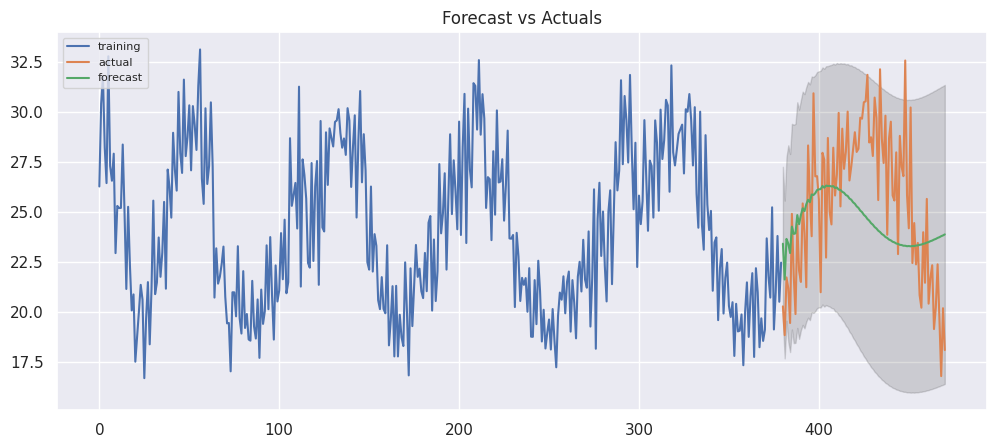

In [34]:

# Make as pandas series
fc_series = pd.Series(fc, index=test2.index)
lower_series = pd.Series(conf[:, 0], index=test2.index)
upper_series = pd.Series(conf[:, 1], index=test2.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train2, label='training')
plt.plot(test2, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [131]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train2, order=(3,1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(31, alpha=0.05)  # 95% conf


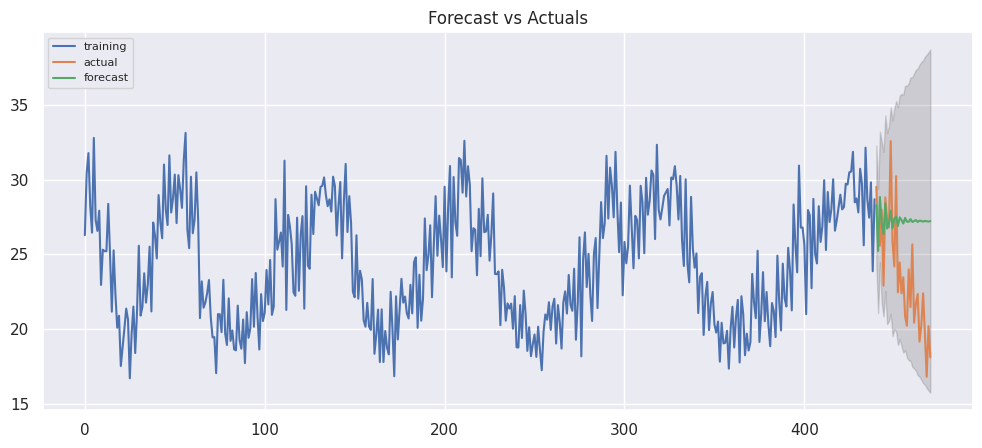

In [132]:

# Make as pandas series
fc_series = pd.Series(fc, index=test2.index)
lower_series = pd.Series(conf[:, 0], index=test2.index)
upper_series = pd.Series(conf[:, 1], index=test2.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train2, label='training')
plt.plot(test2, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()